* Python code replication of: " https://www.kaggle.com/janniskueck/pm1-notebook-inference "
* Created by: Anzony Quispe & Alexander Quispe

This notebook contains an example for teaching.

# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

## Data Analysis

We consider the same subsample of the U.S. Current Population Survey (2015) as in the previous lab. Let us load the data set.



In [1]:
#Load Packages

using Pkg


Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("Plots")
Pkg.add("CategoricalArrays")
Pkg.add("RData")
Pkg.add("Lathe")
Pkg.add("GLM") # package to run models 
Pkg.add("StatsPlots")
Pkg.add("MLBase")
Pkg.add("Tables")
Pkg.add("CovarianceMatrices") # robust standar error
Pkg.add("PyPlot")

using DataFrames
using Dates
using Plots
using Statistics,RData  #upload data of R format 
using CategoricalArrays # categorical data
using DataFrames
using Tables
using Lathe
using GLM
using CovarianceMatrices
using StatsPlots
using Statistics

    Updating registry at `C:\Users\c3318\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\c3318\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes t

In [2]:
rdata_read = load("../data/wage2015_subsample_inference.RData")
data = rdata_read["data"]
names(data)
println("Number of Rows : ", size(data)[1],"\n","Number of Columns : ", size(data)[2],) #rows and columns

Number of Rows : 5150
Number of Columns : 20


***Variable description***

- occ : occupational classification
- ind : industry classification
- lwage : log hourly wage
- sex : gender (1 female) (0 male)
- shs : some high school
- hsg : High school graduated
- scl : Some College
- clg: College Graduate
- ad: Advanced Degree
- ne: Northeast
- mw: Midwest
- so: South
- we: West
- exp1: experience

To start our (causal) analysis, we compare the sample means given gender:

# Unconditional gender gap

In [3]:
# Columns names including scl, clg
Z = select(data, ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"])

# Female subset
data_female = filter(row -> row.sex == 1, data)
Z_female = select(data_female,["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] )

# Male subset
data_male = filter(row -> row.sex == 0, data)
Z_male = select(data_male,["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] )

# Means Dataframe
means = DataFrame( variables = names(Z), All = describe(Z, :mean)[!,2], Men = describe(Z_male,:mean)[!,2], Female = describe(Z_female,:mean)[!,2])


,variables,All,Men,Female
,String,Float64,Float64,Float64
1,lwage,2.97079,2.98783,2.94948
2,sex,0.444466,0.0,1.0
3,shs,0.023301,0.0318071,0.0126693
4,hsg,0.243883,0.294303,0.180865
5,scl,0.278058,0.273331,0.283967
6,clg,0.31767,0.293953,0.347313
7,ad,0.137087,0.106606,0.175186
8,ne,0.227767,0.22195,0.235037
9,mw,0.259612,0.259,0.260376


In particular, the table above shows that the difference in average logwage between men and women is equal to $2.98783$ - $2.94948$ = $0.03835$, as following

In [4]:
wage_gap = (round((mean(Z_male[:,:lwage]) - mean(Z_female[:,:lwage]))*100, digits = 2))

3.83

In [5]:
print("Thus, the unconditional gender wage gap is about ",  wage_gap, "% for the group of never married workers (women get paid less on average in our sample). 
We also observe that never married working women are relatively more educated than working men and have lower working experience.")

Thus, the unconditional gender wage gap is about 3.83% for the group of never married workers (women get paid less on average in our sample). 
We also observe that never married working women are relatively more educated than working men and have lower working experience.

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

\begin{align}
\log(Y) &=\beta D + \epsilon.
\end{align}

We verify this by running an ols regression in Julia.

# Conditional gender gap

In [6]:
data = filter(row->row.scl in [1] ||  row.clg in [1], data)

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,9.61538,2.26336,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,48.0769,3.8728,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,28.8462,3.36198,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11.7308,2.46222,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,19.2308,2.95651,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,12.0192,2.48651,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,13.4615,2.59984,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8,16.3462,2.79399,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,8.65385,2.158,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
# Columns names including scl, clg
Z = select(data, ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"])

# Female subset
data_female = filter(row -> row.sex == 1, data)
Z_female = select(data_female,["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] )

# Male subset
data_male = filter(row -> row.sex == 0, data)
Z_male = select(data_male,["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] )

# Means Dataframe
means = DataFrame( variables = names(Z), All = describe(Z, :mean)[!,2], Men = describe(Z_male,:mean)[!,2], Female = describe(Z_female,:mean)[!,2])

,variables,All,Men,Female
,String,Float64,Float64,Float64
1,lwage,3.00002,3.03841,2.9569
2,sex,0.470991,0.0,1.0
3,shs,0.0,0.0,0.0
4,hsg,0.0,0.0,0.0
5,scl,0.466754,0.481824,0.449827
6,clg,0.533246,0.518176,0.550173
7,ad,0.0,0.0,0.0
8,ne,0.226532,0.219347,0.234602
9,mw,0.265971,0.261245,0.27128


In [8]:
conditional_gender_gap = (round((mean(Z_male[:,:lwage]) - mean(Z_female[:,:lwage]))*100, digits = 2))

8.15

College educated  males have $8.15$\% more salary than a some college educated females

# Regressions

## No Control Model 

In [9]:
nocontrol_model = lm(@formula(lwage ~ sex), data)
nocontrol_est = GLM.coef(nocontrol_model)[2]
nocontrol_se = GLM.coeftable(nocontrol_model).cols[2][2]

nocontrol_se1 = stderror(HC1(), nocontrol_model)[2]
println("The estimated gender coefficient is ", nocontrol_est ," and the corresponding robust standard error is " ,nocontrol_se1)

The estimated gender coefficient is -0.08150855508735176 and the corresponding robust standard error is 0.019586032782704106


## Control Model 

Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

Let us run the ols regression with controls.

In [10]:
# Control vaariables are included
flex = @formula(lwage ~ sex + (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))
control_model = lm(flex , data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lwage ~ 1 + sex + exp1 + exp2 + exp3 + exp4 + shs + hsg + scl + clg + occ2 + ind2 + mw + so + we + exp1 & shs + exp1 & hsg + exp1 & scl + exp1 & clg + exp1 & occ2 + exp1 & ind2 + exp1 & mw + exp1 & so + exp1 & we + exp2 & shs + exp2 & hsg + exp2 & scl + exp2 & clg + exp2 & occ2 + exp2 & ind2 + exp2 & mw + exp2 & so + exp2 & we + exp3 & shs + exp3 & hsg + exp3 & scl + exp3 & clg + exp3 & occ2 + exp3 & ind2 + exp3 & mw + exp3 & so + exp3 & we + exp4 & shs + exp4 & hsg + exp4 & scl + exp4 & clg + exp4 & occ2 + exp4 & ind2 + exp4 & mw + exp4 & so + exp4 & we

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                        Coef.   Std. Error       t  Pr(>|t|)     Lower 95%      Upper 95%
──────────────────────────────────────────────────────────────────

In [11]:
control_est = GLM.coef(control_model)[2]
print("The coefficient for OLS with controls is ", control_est, "\n")
control_se = GLM.coeftable(control_model).cols[2][2]
print("The standar error is ", control_se, "\n")
control_se1 = stderror( HC0(), control_model)[2]
control_se1 = 0.0183528
print("The robust standar error is " ,control_se1)

The coefficient for OLS with controls is -0.0530623403562567
The standar error is 0.01935319255831502
The robust standar error is 0.0183528

In [12]:
println("Coefficient for OLS with controls " , control_est, "robust standard error:", control_se1)

Coefficient for OLS with controls -0.0530623403562567robust standard error:0.0183528


The estimated regression coefficient $\beta_1\approx-0.05306$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $4$\% for women increases to about $7$\% after controlling for worker characteristics.  


Next, we are using the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

## Partialling-Out using ols

In [13]:
# models
# model for Y
flex_y = @formula(lwage ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))
flex_d = @formula(sex ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))

# partialling-out the linear effect of W from Y
# keep residuals
t_Y = residuals(lm(flex_y, data))

# partialling-out the linear effect of W from D
# keep residuals
t_D = residuals(lm(flex_d, data))

data_res = DataFrame(t_Y = t_Y, t_D = t_D )
# regression of Y on D after partialling-out the effect of W

partial_fit = lm(@formula(t_Y ~ t_D), data_res)

partial_est = GLM.coef(partial_fit)[2]

# standard error
partial_se = GLM.coeftable(partial_fit).cols[2][2]

partial_se1 = stderror( HC0(), partial_fit)[2]

#condifence interval
GLM.confint(partial_fit)[2,:]

2-element Vector{Float64}:
 -0.08957069899693074
 -0.016553981718577186

In [14]:
println("Coefficient for D via partiallig-out ", partial_est, " robust standard error:", control_se1 )

Coefficient for D via partiallig-out -0.05306234035775396 robust standard error:0.0183528


Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

In the following, we illustrate the partialling-out approach using lasso instead of ols. 

## Summarize the results

In [15]:
DataFrame(modelos = [ "Without controls", "full reg", "partial reg" ], 
Estimate = [nocontrol_est,control_est, partial_est], 
StdError = [nocontrol_se1,control_se1, partial_se1])

,modelos,Estimate,StdError
,String,Float64,Float64
1,Without controls,-0.0815086,0.019586
2,full reg,-0.0530623,0.0183528
3,partial reg,-0.0530623,0.0183528


It it worth to notice that controlling for worker characteristics increases the gender wage gap from less that 4\% to 7\%. The controls we used in our analysis include 5 educational attainment indicators (less than high school graduates, high school graduates, some college, college graduate, and advanced degree), 4 region indicators (midwest, south, west, and northeast);  a quartic term (first, second, third, and fourth power) in experience and 22 occupation and 23 industry indicators.

Keep in mind that the predictive effect (PE) does not only measures discrimination (causal effect of being female), it also may reflect
selection effects of unobserved differences in covariates between men and women in our sample.


Next we try "extra" flexible model, where we take interactions of all controls, giving us about 1000 controls.

## **Statistics** 

#### Subset data to generate figures

In [16]:
data_female = filter(row -> row.sex == 1, data)
data_male = filter(row -> row.sex == 0, data)

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,48.0769,3.8728,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,8.65385,2.158,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,19.2308,2.95651,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,12.0,2.48491,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,16.8269,2.82298,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,19.6703,2.97911,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,12.9371,2.5601,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,8.50592,2.14076,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,33.9893,3.52604,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
names(data_male)

20-element Vector{String}:
 "wage"
 "lwage"
 "sex"
 "shs"
 "hsg"
 "scl"
 "clg"
 "ad"
 "mw"
 "so"
 "we"
 "ne"
 "exp1"
 "exp2"
 "exp3"
 "exp4"
 "occ"
 "occ2"
 "ind"
 "ind2"

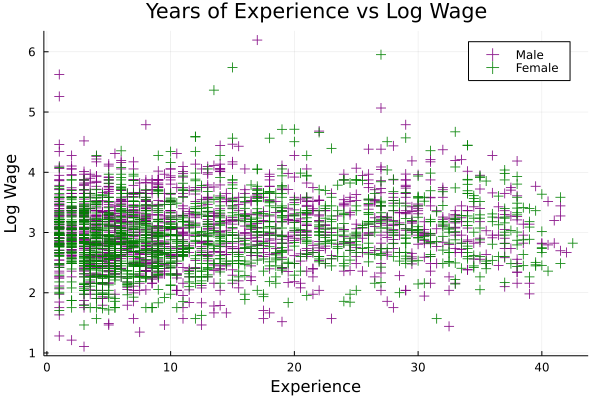

In [18]:

Plot1 = scatter(data_male.exp1,data_male.lwage, label = "Male", marker = (:+,5), color = :purple)
scatter!(data_female.exp1,data_female.lwage, title = "Years of Experience vs Log Wage",
    xlabel = "Experience", ylabel = "Log Wage", label="Female",legend = true, marker = (:+,5), color = :green)


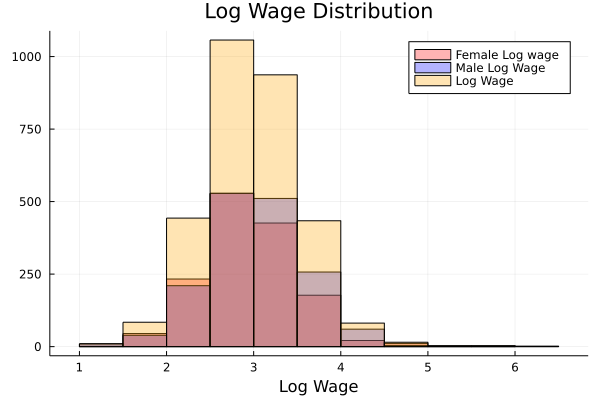

In [19]:
Plot2 = histogram(data_female.lwage, label = "Female Log wage",nbins=20, color=:red, fillalpha=.3)
histogram!(data_male.lwage, nbins=20, label = "Male Log Wage", color=:blue, fillalpha=.3)
histogram!(data.lwage, nbins=20, label = "Log Wage", color=:orange, fillalpha=.3,legend=true, xlabel = "Log Wage", title = "Log Wage Distribution")

## **Paper Figure**

In [21]:
#Subset
data_scl = filter(row -> row.scl == 1, data)
data_scl= select(data_scl,["lwage", "exp1"] )
data_scl = sort(data_scl, :exp1)

data_clg = filter(row -> row.clg == 1, data)
data_clg= select(data_clg,["lwage", "exp1"] )
data_clg = sort(data_clg, :exp1)

,lwage,exp1
,Float64,Float64
1,2.46222,1.0
2,3.07429,1.0
3,2.48651,1.0
4,2.89767,1.0
5,2.90522,1.0
6,2.82298,1.0
7,2.95651,1.0
8,3.17966,1.0
9,1.98306,1.0


In [23]:
data_scl = groupby(data_scl, :exp1)
data_scl = combine(data_scl, :lwage => mean)

,exp1,lwage_mean
,Float64,Float64
1,3.0,2.69388
2,3.5,2.72932
3,4.0,2.69642
4,4.5,2.61163
5,5.0,2.72719
6,5.5,2.66762
7,6.0,2.99209
8,6.5,2.7422
9,7.0,2.78097


In [24]:
data_clg = groupby(data_clg, :exp1)
data_clg = combine(data_clg, :lwage => mean)

,exp1,lwage_mean
,Float64,Float64
1,1.0,3.03114
2,2.0,3.01949
3,3.0,3.06155
4,4.0,3.07077
5,5.0,3.0309
6,6.0,3.18229
7,7.0,3.10777
8,8.0,3.14227
9,9.0,3.03809


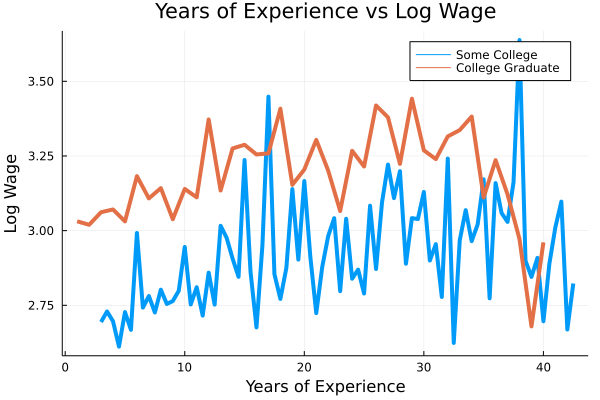

In [29]:
Plot3 = plot(data_scl.exp1, data_scl.lwage_mean, title = "Years of Experience vs Log Wage", lw = 4, label = "Some College")
plot!(data_clg.exp1, data_clg.lwage_mean, lw = 4, xlabel = "Years of Experience", ylabel = "Log Wage", label="College Graduate",legend = true)